<a href="https://colab.research.google.com/github/Dmitrii173173/image_detection_v01/blob/main/image_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from google.colab import drive
import os
import time
from PIL import Image


In [36]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:

# A function that measures the speed of reading files from a directory
def get_time_read(dir_read):
  cur_time = time.time()          # Recording the current time
  num = 0                         # Number of files read
  list_dir = os.listdir(dir_read) # Getting a list of subdirectories
  print(list_dir)                  
  for cur_dir in list_dir:
    list_file = os.listdir(dir_read + '/' + cur_dir)
    for cur_file in list_file:
      img = Image.open(dir_read + '/' + cur_dir + '/' + cur_file) # Reading the image
      num += 1
  print('Количество загруженных изображений =', num)
  print('Затрачено времени -', round(time.time() - cur_time, 2), 'cек')

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [39]:
data_path = '/data_tracking_image_my2/training/'

In [40]:
# Creating a neural network model
model = Sequential()
feature_dim = 256
model.add(GRU(units=64, input_shape=(None, feature_dim)))  # feature_dim dimension of image features
# model.add(Dense(units=num_classes, activation='softmax'))  # num_classes for the number of classes
input_dim = (32, 32, 32)
num_classes = 10  # required number of classes

model.add(Dense(units=64, activation='relu', input_shape=(input_dim,)))  # input_dim - input dimension
model.add(Dense(units=num_classes, activation='softmax'))

In [41]:
# Model compilation / 模型编译
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose

In [45]:
# Autoencoder architecture / 自动编码器架构
autoencoder = Sequential()

In [46]:
# Adding an encoder layer / 添加编码器层
image_height = 64
image_width = 64
num_channels = 3
autoencoder.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
autoencoder.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'))

In [47]:
# Adding a decoder layer / 添加解码器层
autoencoder.add(Conv2DTranspose(filters=8, kernel_size=(3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))



In [48]:
# Adding an Output Image Layer / 添加输出图像层
autoencoder.add(Conv2D(filters=num_channels, kernel_size=(3, 3), activation='sigmoid', padding='same'))


In [49]:
# Compiling the Autoencoder Model / 编译自动编码器模型
autoencoder.compile(optimizer='adam', loss='mse')


In [52]:
# Data Folder / 数据文件夹
data_folder = '/content/drive/MyDrive/data_tracking_image_my2/training/'

# Empty lists for storing images / 用于存储图像的空列表
images = []

# Reading and preprocessing images / 读取和预处理图像
for root, _, files in os.walk(data_folder):
    for image_file in files:
        image_path = os.path.join(root, image_file)
        image = cv2.imread(image_path)
        # Necessary transformations to the image / 对图像进行必要的转换
        # For example, resizing, normalizing, etc. / 例如，调整大小、规范化等。
        image = cv2.resize(image, (image_width, image_height))
        image = image / 255.0  # Normalizing Pixel Values / 归一化像素值
        images.append(image)

# Convert image list to numpy array / 将图像列表转换为 numpy 数组
x_train = np.array(images)

# Separation into training and validation sets / 分为训练集和验证集
# Approximate ratio of 80% for training, 20% for validation 
# 大约 80% 的比例用于训练，20% 用于验证
split_ratio = 0.8  
split_index = int(len(x_train) * split_ratio)
x_val = x_train[split_index:]
x_train = x_train[:split_index]


In [53]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                61824     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 66,634
Trainable params: 66,634
Non-trainable params: 0
_________________________________________________________________


In [54]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape

# Остальной код...

batch_size = 32  # Approximate data packet size / 近似数据包大小
num_epochs = 10  # Approximate number of epochs / 大约的纪元数

# Define input_shape according to image dimensions / 根据图像尺寸定义 input_shape
input_shape = (image_height, image_width, num_channels)

# Building and compiling the model / 构建和编译模型
autoencoder = Sequential()
autoencoder.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
autoencoder.add(Flatten())
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(image_height * image_width * num_channels, activation='sigmoid'))
autoencoder.add(Reshape((image_height, image_width, num_channels)))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Model Training / 模型训练
autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_val, x_val))


Epoch 1/10
154/154 [==============================] - 49s 311ms/step - loss: 0.0658 - val_loss: 0.0654
Epoch 2/10
154/154 [==============================] - 47s 305ms/step - loss: 0.0397 - val_loss: 0.0592
Epoch 3/10
154/154 [==============================] - 47s 306ms/step - loss: 0.0335 - val_loss: 0.0526
Epoch 4/10
154/154 [==============================] - 48s 309ms/step - loss: 0.0304 - val_loss: 0.0528
Epoch 5/10
154/154 [==============================] - 50s 326ms/step - loss: 0.0292 - val_loss: 0.0487
Epoch 6/10
154/154 [==============================] - 50s 323ms/step - loss: 0.0279 - val_loss: 0.0483
Epoch 7/10
154/154 [==============================] - 49s 315ms/step - loss: 0.0271 - val_loss: 0.0469
Epoch 8/10
154/154 [==============================] - 51s 334ms/step - loss: 0.0264 - val_loss: 0.0470
Epoch 9/10
154/154 [==============================] - 50s 326ms/step - loss: 0.0258 - val_loss: 0.0468
Epoch 10/10
154/154 [==============================] - 48s 314ms/step - l

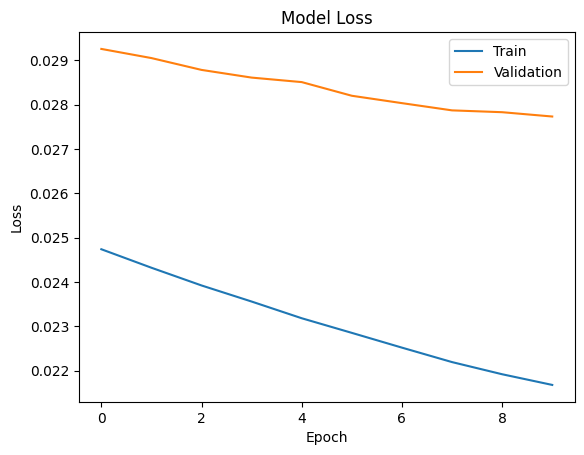

In [55]:
import matplotlib.pyplot as plt

# Loss chart / 损失图
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Accuracy Graph / 精度图
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()


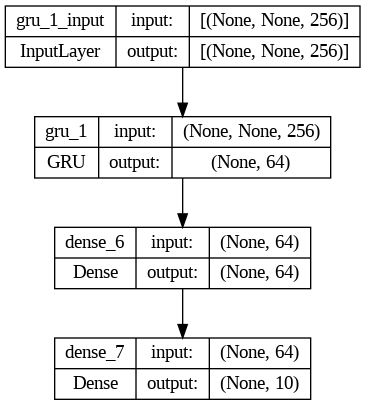

In [58]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


